In [ ]:
! pip install sklearn

# Imports

In [1]:
from fastai.text import *

In [2]:
import sys

sys.path.append("../../")
from eval.exp.nb_evaluation import *

sys.path.append("../../../")
from src.proc.exp.nb_proc import *
from src.prep.exp.nb_prep import *

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# setup paths and model type
model_path = Path("/tf/data/models")
data_path  = Path("/tf/data/datasets")

task_type = "merged"

# Load Data

In [21]:
df_trn, df_val, df_tst = read_data(data_path/task_type)

In [4]:
bs = 8

In [22]:
data = gen_lm_data(df_trn, df_val, task_type, data_path, sample = 0.30, bs = bs)
data.save(task_type + '/data_lm_10pct.pkl')

In [23]:
data.save(task_type + '/data_lm_30pct.pkl')

In [ ]:
data.label_list

In [6]:
data = load_data(data_path/task_type, 'data_lm_1pct.pkl', bs=bs)

In [24]:
len(data.train_ds), len(data.valid_ds)

(147871, 31609)

# Model Setup

In [25]:
pretrained = False

In [26]:
learn = language_model_learner(data, AWD_LSTM, drop_mult = 0.3, pretrained = pretrained)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


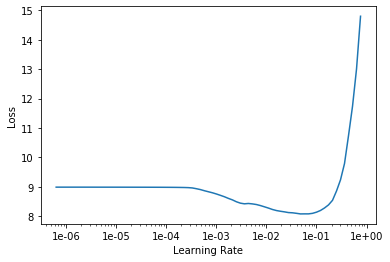

In [27]:
learn.lr_find()
learn.recorder.plot()

# Model Training

In [28]:
# Set hyperparameters
max_lr = 1e-2
moms = (0.5, .75)
pct_strt = 0.02

In [ ]:
learn.fit_one_cycle(10, max_lr) #, moms=moms, pct_start = pct_strt)

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.save(model_path/'awd_lstm_do_30pct')

In [ ]:
learn.load(model_path/'awd_lstm_do_30pct')

In [ ]:
learn.export(file = model_path/'awd_lstm_do_30pc.pkl')

In [ ]:
learn = load_model(df_trn, file = model_path/'awd_lstm_do_30pc.pkl')

In [ ]:
learn.recorder.plot_losses()

# Model Evaluation

In [ ]:
print(df_val["query"][50000])
print("\n\n" + df_val["res"][50000])

In [ ]:
print(df_val["query"][75_000])
print("\n\n" + df_val["res"][75_000])

In [ ]:
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
sp.Load(str(data_path/"merged/model.model"))

In [ ]:
TEXT = df_val["query"][50_000]
N_WORDS = 200
N_SENTENCES = 2

In [ ]:
print(TEXT)

In [ ]:
print(sp.DecodePieces(learn.predict(TEXT, 100, temperature=0.75).split(" ")))

# Evaluation

In [ ]:
learn.predict??

In [ ]:
# Grabs entire model's response up until special xxbos token,
# i.e. once model begins a new sentence we consider the model finished with its answer.
def get_res(mdl, inpt, n_toks = 1_000):
    res = mdl.predict(inpt, n_toks, temperature=0.75).split(" ")
    res = sp.DecodePieces(res).split(" ")
    try:
        end_res = res.index("xxbos")
    except:
        end_res = len(res) - 1
    
    res = " ".join(res[:end_res])[len(inpt.replace(" ", '')):]
    
    return res

In [ ]:
res = get_res(learn, "public static void main() {return;}<$bug$>", n_toks = 10)
res # [0:len("public static void main() {return;}<$bug$>")]

In [ ]:
# Evaluation metrics for vulnerability detection - Accuracy, Precision, Recall
def eval_vuln(mdl, tst):
    tps, tns, fps, fns = 0, 0, 0, 0
    for inpt, lbl in zip(tst["query"], tst["res"]):
        pred = get_res(mdl, inpt, n_toks = 10)
        if lbl == "yes":
            if pred == lbl:
                tps += 1
            else: fns += 1
        else:
            if pred == lbl:
                tns += 1
            else: fps += 1
            
    acc   = (tps + tns) / len(tst)
    prec  = tps / (tps + fps) if (tps + fps) != 0 else 0.
    recal = tps / (tps + fns) if (tps + fns) != 0 else 0.
    
    return acc, prec, recal

In [ ]:
acc, prec, recal = eval_vuln(learn, df_val[:300])

In [ ]:
acc, prec, recal

In [ ]:
len(df_val[:10])